<a href="https://colab.research.google.com/github/Piyush811999/BTP_TimeSeriesAnalysis/blob/main/BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of USD/INR Exchange rate

### Task
To utilize various time series concepts to analyse and predict the daily exchange rate of Indian Rupee against the United States Dollar. 

Historical Data Source - https://www.investing.com/currencies/usd-inr-historical-data



### Hypothesis 
* Value of USD increases over most years ( due to US's rising Economy ) 
* Low value of USD during around 2008 period due to the Great recession preiod. 
* Some monthly pattern du to some seasonal factors such as Tourism, seasonal Import/ Export of goods 



## Understanding Data Set


#### Getting Systems ready and loading the data

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from pandas import Series
%matplotlib inline 
import warnings
from google.colab import drive
drive.mount("/content/drive")

# ignoring warnings 
warnings.filterwarnings("ignore")

# reading data from csv
# Also parsing dates as Datetime so that we can extract features like year and months later on.
# making date colum out index since we are doing Time Series analysis 
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/USD_INR Historical Data.csv", index_col='Date', parse_dates=True)

# checking current python version
print("Using python version " + sys.version)

data.head()

Mounted at /content/drive
Using python version 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


,Price,Open,High,Low,Change %
Date,,,,,
2020-12-30,73.127,73.370,73.398,73.135,-0.36%
2020-12-29,73.390,73.545,73.545,73.313,-0.21%
2020-12-28,73.546,73.558,73.613,73.457,0.01%
2020-12-24,73.540,73.800,73.840,73.506,-0.31%
2020-12-23,73.770,73.905,73.905,73.654,-0.11%


#### Filling missing data and Extracting features
* Adding the missing dates and filling it with last known value. 
* Extracting year, month and day from Date so that we can examin them later 

In [ ]:
# adding missing dates and filling with last known value
index = pd.date_range('01-02-2002','12-31-2020')
data = data.reindex(index, method='backfill')



# Dropping colums that we don't need
data = data.drop(['Open', 'High', 'Low', 'Change %'], axis= 1)

# making a copy 
data_copy = data.copy()

# Extracting year, month and day from the date 
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day

data.tail()

,Price,year,month,day
2020-12-27,73.540,2020,12,27
2020-12-28,73.546,2020,12,28
2020-12-29,73.390,2020,12,29
2020-12-30,73.127,2020,12,30
2020-12-31,73.127,2020,12,31


#### Ploting the data

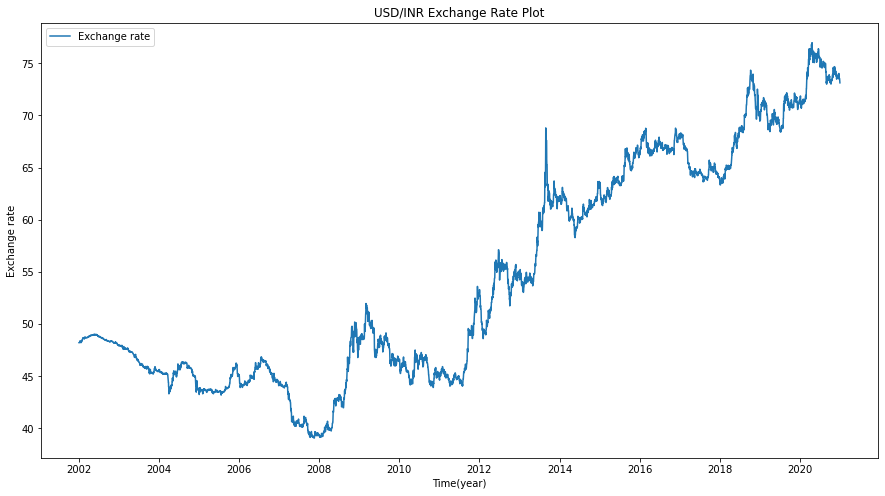

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(data['Price'], label='Exchange rate')
plt.title('USD/INR Exchange Rate Plot')
plt.xlabel('Time(year)')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')

Here we can infer that there is an increasing trend in the series for most part, the exchange rate increases with respect to time. We can also see that there is a dip arroud 2007-2009 in exchange rate. 

#### Exploratory Analysis 
Trying to validate our hypothesis and making other infrences from the dataset 

##### Yearly avg.

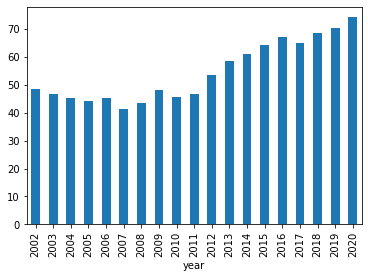

In [ ]:
data.groupby('year')['Price'].mean().plot.bar()

* We can see a the growth in the exchange rate with respect to year which validates our 1st Hypothesis 
* We can also see dip in growth rate during 2007-2008, which validates out 2nd Hypothesis.

##### Monthly Avg. 

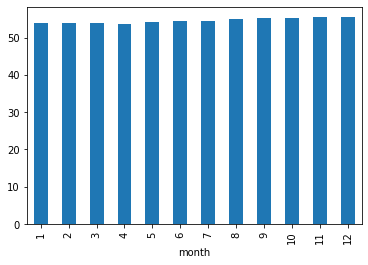

In [ ]:
# monthly chart 
data.groupby('month')['Price'].mean().plot.bar()

* We can't see any strong patterns here, this may be due to the instablity during the Great Recession ( 2007 -2008 ) 
* **From now onwards we will work on the data from 2010 onwards for more consisten results.** 

month
1     60.174850
2     60.143630
3     60.040185
4     60.006233
5     60.662012
6     61.244045
7     61.257548
8     62.014827
9     62.428924
10    62.217848
11    62.805582
12    62.795721
Name: Price, dtype: float64

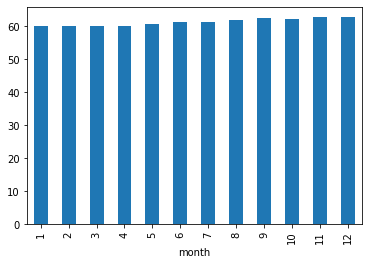

In [ ]:
new_data = data['01-01-2010':'12-31-2020']
new_data.groupby('month')['Price'].mean().plot.bar()
new_data.groupby('month')['Price'].mean()

* We can see decrease in avg. monthly exchange rate form Jan to Apr and and Increase from there on. 
* The monthly increase is expected due to obvious increasig trend but we can also observe some decrease from jan to Apr, From this we can infer that there is some kind of seasonal pattern.
* This validates out 3rd hypothesis. 

## Modeling and Evaluation




### Splitting Data into traing, testing and validation part

Before training or model we need to split our data into training data, validation data, and testing data 

* Training Data ( 10 years )
 * This is the data set we will use to train/ fit our models on once we have figured out the the best parameters for out model. 
* Validation Data ( 3 months )
  * This is the data set we will use to check our tentatively performace and tune our parameters
* Training - validation ( 9 years, 9 months )
 * We will train this data set first and try to figure out parameters too maximize our performance on the validation dataset. 
* Testing Data 
  * We will use two types of testing to measure performance of our models
   * predicting a month in advance ( 1 month )
   * predicting a year in advance ( 1 year )


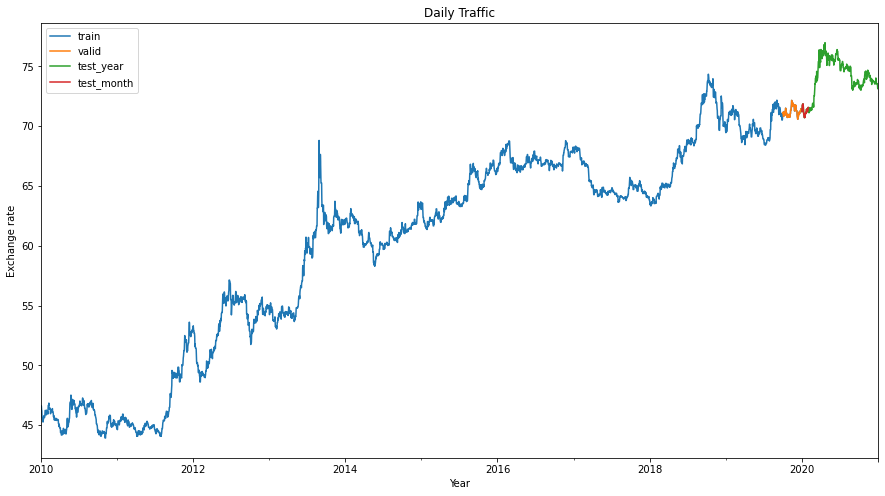

In [ ]:
train = data['01-01-2010':'01-01-2020']
valid = data['10-01-2019':'01-01-2020']
train_valid = data['01-01-2010':'10-01-2019']
test_month = data['01-01-2020':'02-01-2020']
test_year = data['01-01-2020':'01-01-2021']

train.Price.plot(figsize=(15,8), title = 'Daily Traffic', label = 'train')
valid.Price.plot(label = 'valid')
test_year.Price.plot(label='test_year')
test_month.Price.plot(label= 'test_month')
plt.xlabel('Year')
plt.ylabel('Exchange rate')
plt.legend(loc='best')
plt.show()

### Naive Approach 
Next expected point is equal to last observed point. 

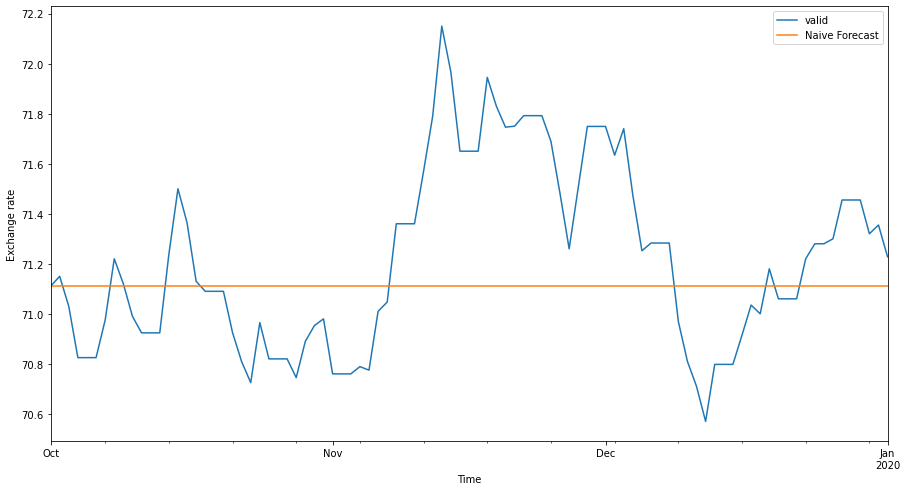

RMSE for Naive approach for validation data 0.3777
Mean Absolute Percent Error for validation data :  0.43%


In [ ]:
dd = np.asarray(train_valid.Price)
y_hat = valid.copy()
# last observed value 
y_hat['naive'] = dd[len(dd)-1]

valid.Price.plot(figsize=(15,8), label = 'valid')
y_hat.naive.plot(figsize=(15,8), label = 'Naive Forecast')
plt.xlabel('Time')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()


# calculating rmse 
from sklearn.metrics import mean_squared_error
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Price, y_hat.naive))

residuals = valid.Price - y_hat.naive


# root mean square error 
rmse_naive = round(np.sqrt(np.mean(residuals**2)),4)
print("RMSE for Naive approach for validation data " + str(rmse_naive))

# mean absolute percent error
mape_naive = round(np.mean(abs(residuals/valid.Price)),4)
print("Mean Absolute Percent Error for validation data :  " + str(mape_naive*100) + "%")

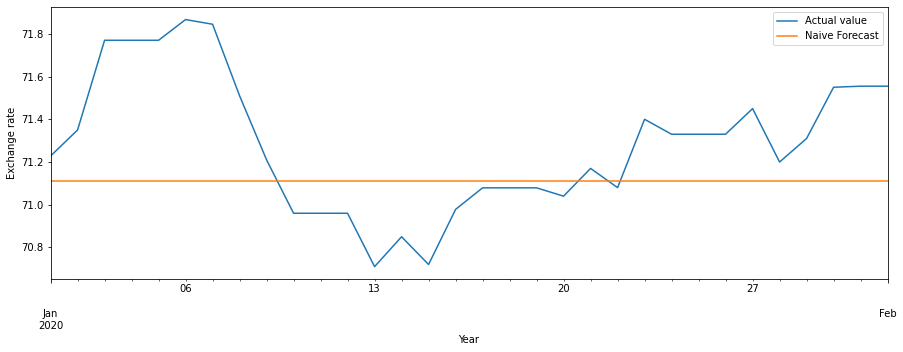

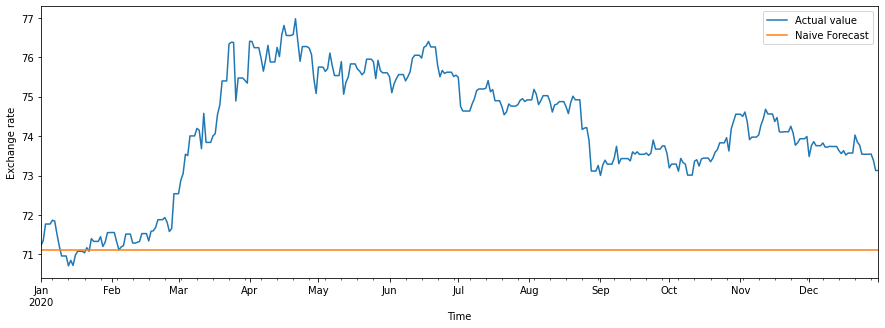

RMSE for Naive approach on monthly prediction is 0.3589
RMSE for Naive approach on yearly prediction is 3.3771
Mean Absolute Percent Error for monthly prediction : 0.4%
Mean Absolute Percent Error for yearly prediction :  4.04%


In [ ]:
dd = np.asarray(train_valid.Price)

y_hat = test_month.copy()
y_hat_year = test_year.copy()
# last observed value 
y_hat['naive'] = dd[len(dd)-1]
y_hat_year['naive'] = dd[len(dd)-1]


test_month.Price.plot(figsize=(15,5), label = 'Actual value')
y_hat.naive.plot(figsize=(15,5), label = 'Naive Forecast')
plt.xlabel('Year')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()


# train.Price.plot(figsize=(15,8), title = 'Daily Traffic', label = 'train')
test_year.Price.plot(figsize=(15,5), label = 'Actual value')
y_hat_year.naive.plot(figsize=(15,5), label = 'Naive Forecast')
plt.xlabel('Time')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()



# calculating rmse 
from sklearn.metrics import mean_squared_error
from math import sqrt 

residuals_month = test_month.Price - y_hat.naive
residuals_year = test_year.Price - y_hat_year.naive


# root mean square error 
rmse_naive_month = round(np.sqrt(np.mean(residuals_month**2)),4)
rmse_naive_year = round(np.sqrt(np.mean(residuals_year**2)),4)
print("RMSE for Naive approach on monthly prediction is " + str(rmse_naive_month))
print("RMSE for Naive approach on yearly prediction is " + str(rmse_naive_year))

# mean absolute percent error
mape_naive_month = round(np.mean(abs(residuals_month/test_month.Price)),4)
mape_naive_year = round(np.mean(abs(residuals_year/test_year.Price)),4)
print("Mean Absolute Percent Error for monthly prediction : " + str(mape_naive_month*100) + "%")
print("Mean Absolute Percent Error for yearly prediction :  " + str(mape_naive_year*100) + "%")

### Exponential Smoothing 

* Simple Exponential Smoothing 
 * Suitable for time series with no trend and no seasonality 
 * F(t) = F(t-1) + alpha*Et 
 * Et = previoud error ( actual - predicted ) 
 * alpha = learning rate / Smoothing constant ( over smoothing --> under smoothing ) 

* Holt's Exponential Smoothing 
 * For series with trend and no seasonality 
 * Also called *double exponential smoothing* because we update both level and trend 
 * Trend can be additive/linear and multiplicative/Exponential 
 * Has two smoothing constants aplha and beta one for level and other for trend 

* Holt-Winter's Exponential Smoothing
 * For series with tend and seasonality 
 * Also called *Tripple Exponential Smoothing* 
 * Trend and Seasonality can be linear ( additive ) or exponentila ( multiplicative)
 * Has 3 smoothing constant one for each Level, Trend and Seasonality. 


Paramater such as smoothing constants can be tuned with respect to performance measure on validation dataset ( rmse etc. ) but that can also lead to overfittling.


#### Tuning Parameters

Result for Validation dataset : 

RMSE for SES model : 0.4785
RMSE for Holt's model : 0.3638
RMSE for Holt Winter model : 0.3638

Mean Absolute Percent Error for SES model : 0.51%
Mean Absolute Percent Error for Holt's model : 0.42%
Mean Absolute Percent Error for Holt Winter model : 0.42%



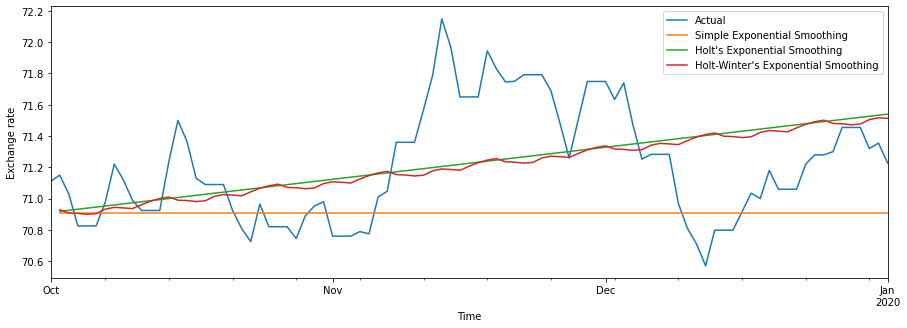

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt


def exponentialSmoothing(training_data, testing_data):

  y_exp_smoothing = testing_data.copy()
  testing_data.Price.plot(figsize = (15, 5), label = "Actual")

  # Simple Exponetial smoothing 
  ses_model = SimpleExpSmoothing(training_data['Price']).fit(smoothing_level = 0.6, optimized= True)
  y_exp_smoothing['ses'] = ses_model.forecast(len(testing_data))
  y_exp_smoothing.ses.plot(label = "Simple Exponential Smoothing")

  residuals_ses = y_exp_smoothing['ses'] - testing_data.Price
  rmse_ses = round(np.sqrt(np.mean(residuals_ses**2)),4)
  mape_ses = round(np.mean(abs(residuals_ses/testing_data.Price)),4)



  # Holt's Exponential smoothing 
  holt_model = Holt(training_data['Price'], exponential=False).fit(smoothing_level = 0.6, optimized= True)
  y_exp_smoothing['holt'] = holt_model.forecast(len(testing_data))
  y_exp_smoothing.holt.plot(label = "Holt's Exponential Smoothing")

  residuals_holt = y_exp_smoothing['holt'] - testing_data.Price
  rmse_holt = round(np.sqrt(np.mean(residuals_holt**2)),4)
  mape_holt = round(np.mean(abs(residuals_holt/testing_data.Price)),4)



  # Holt Winter Exponential smoothing  
  holt_winter_model = ExponentialSmoothing(training_data['Price'], trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit(smoothing_level = 0.6, optimized= True)
  y_exp_smoothing['hwm'] = holt_winter_model.forecast(len(testing_data))
  y_exp_smoothing.hwm.plot(label = "Holt-Winter's Exponential Smoothing")

  residuals_hwm = y_exp_smoothing['hwm'] - testing_data.Price
  rmse_hwm = round(np.sqrt(np.mean(residuals_hwm**2)),4)
  mape_hwm = round(np.mean(abs(residuals_hwm/testing_data.Price)),4)

  # printing results 
  print("RMSE for SES model : "+ str(rmse_ses))
  print("RMSE for Holt's model : "+ str(rmse_holt))
  print("RMSE for Holt Winter model : "+ str(rmse_hwm))
  print("")
  print("Mean Absolute Percent Error for SES model : " + str(mape_ses*100) + "%")
  print("Mean Absolute Percent Error for Holt's model : " + str(mape_holt*100) + "%")
  print("Mean Absolute Percent Error for Holt Winter model : " + str(mape_hwm*100) + "%")
  print("")

  plt.xlabel('Time')
  plt.ylabel('Exchange rate')
  plt.legend(loc = 'best')
  plt.show()


print("Result for Validation dataset : \n")
exponentialSmoothing(train_valid,valid)



#### Testing

Result for monthly prediction : 

RMSE for SES model : 0.3204
RMSE for Holt's model : 0.3514
RMSE for Holt Winter model : 0.349

Mean Absolute Percent Error for SES model : 0.38%
Mean Absolute Percent Error for Holt's model : 0.42%
Mean Absolute Percent Error for Holt Winter model : 0.42%



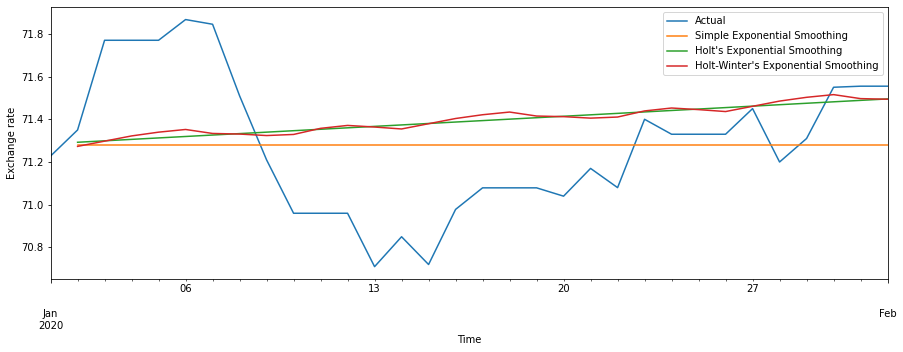

Result for yearly prediction : 

RMSE for SES model : 3.2298
RMSE for Holt's model : 2.2367
RMSE for Holt Winter model : 2.2309

Mean Absolute Percent Error for SES model : 3.84%
Mean Absolute Percent Error for Holt's model : 2.23%
Mean Absolute Percent Error for Holt Winter model : 2.22%



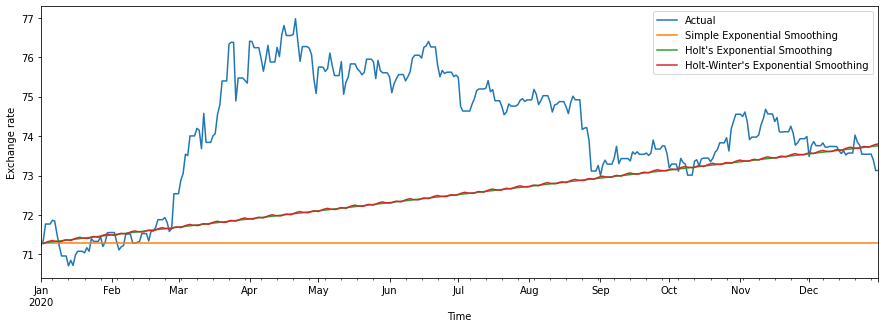

In [ ]:
print("Result for monthly prediction : \n")
exponentialSmoothing(train, test_month)

print("Result for yearly prediction : \n")
exponentialSmoothing(train, test_year)

### ARIMA

#### Augmented Dickey Fuler Test

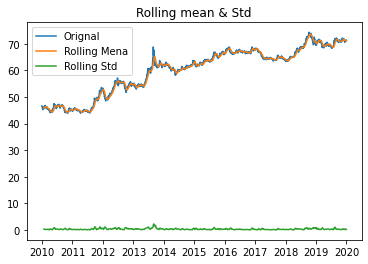

Results of Dickey-Fuller Test:
Test Static                      -1.192659
p-value                           0.676746
#Lags Used                       12.000000
Number of Observations used    3640.000000
Critical Value (1%)              -3.432148
Critical Value (5%)              -2.862334
Critical Value (10%)             -2.567193
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams

def rolling_statics(ts):

  # Determine rolling statics 
  rolmean = ts.rolling(24).mean()
  rolstd = ts.rolling(24).std()

  # Ploting the rolling statics 
  orig = plt.plot(ts, label = 'Orignal')
  mean = plt.plot(rolmean, label = 'Rolling Mena' )
  std = plt.plot(rolstd, label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling mean & Std')
  rcParams['figure.figsize'] = 15,5

  plt.show(block = False)


def adf_test(ts):

  # Dickey fuller test 
  print('Results of Dickey-Fuller Test:')

  # what is autolag parm ?? 
  dftest = adfuller(ts, autolag= 'AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Static', 'p-value', '#Lags Used', 'Number of Observations used'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)


rolling_statics(train['Price'])
adf_test(train['Price'])

* The time-series is not stationary ( p-value > 0.05 ) 
* To apply AR, MA models we first have to make our time series stationary. 

#### Making TimeSeries Stationary 
* By taking log and diffrencing time series with lagged version of itself

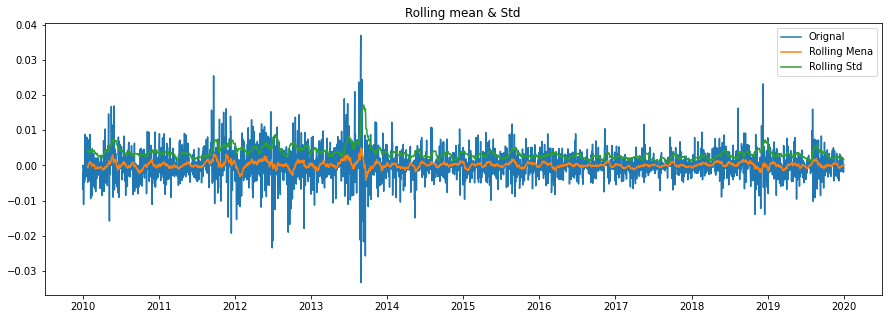

Results of Dickey-Fuller Test:
Test Static                   -1.655155e+01
p-value                        1.943044e-29
#Lags Used                     1.100000e+01
Number of Observations used    3.640000e+03
Critical Value (1%)           -3.432148e+00
Critical Value (5%)           -2.862334e+00
Critical Value (10%)          -2.567193e+00
dtype: float64


In [ ]:
train_log = np.log(train['Price'])
train_log_diff = train_log - train_log.shift(1)
train_log_diff.dropna(inplace=True)
rolling_statics(train_log_diff)
adf_test(train_log_diff)

train_valid_log = np.log(train_valid['Price'])
train_valid_log_diff = train_valid_log - train_valid_log.shift(1)
train_valid_log_diff.dropna(inplace=True)

p-value < 0.05, hence our code is stationary and we can apply continue applying AR/MA model.

#### ACF and PACF plot

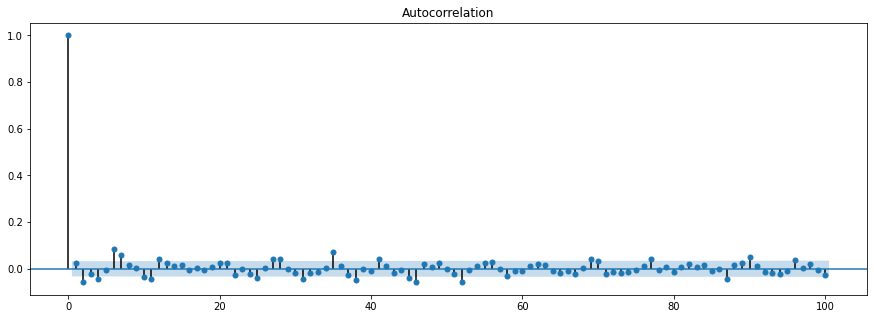

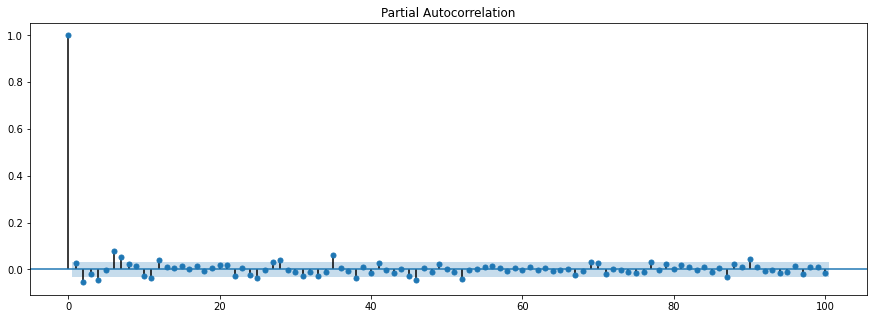

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(train_log_diff, lags=100)
pacf_plot = plot_pacf(train_log_diff, lags=100)

* From the looks of it dosen't seem like either a strong AR process or a MA process 
* Both ACF and PACF have slightly significant spikes at lags - 2,4,6,7,11...
* From the PACF we can infer that this might be a SARIMA process seasonality might be 10 or 11 ( for SARIMA )

#### ARIMA Code

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

def arima_model_results(train_data,test_data, start_date, end_date, ar_lag, diff, ma_lag):

  ar_model = ARIMA(train_data, order=(ar_lag,diff,ma_lag)).fit()

  # predicting and reversing the data back to same scale ( integrating and exponentiating)
  ar_predict = ar_model.predict(start=start_date, end=end_date)
  ar_predict = ar_predict.cumsum().shift().fillna(0)
  ar_predict1 = pd.Series(np.ones(test_data.shape[0]) * np.log(test_data['Price'])[0], index = test_data.index)
  ar_predict1 = ar_predict1.add(ar_predict, fill_value = 0)
  ar_predict = np.exp(ar_predict1)

  plt.plot(test_data['Price'], label = 'Actual')
  plt.plot(ar_predict, label = 'Predict')
  plt.xlabel('Time')
  plt.ylabel('Exchange rate')
  plt.legend(loc='best')


  residuals = test_data.Price - ar_predict
  rmse_ar = round(np.sqrt(np.mean(residuals**2)),4)
  mape_ar = round(np.mean(abs(residuals/test_data.Price)),4)

  print("RMSE for AR model is: "+ str(rmse_ar))
  print("Mean Absolute Percent Error: " + str(mape_ar*100) + "%")

  plt.show()
  
  # print(ar_model.summary())

#### AR Model
Using AR(2)

##### Tuning 

Result for Validation dataset : 

RMSE for AR model is: 0.4611
Mean Absolute Percent Error: 0.54%


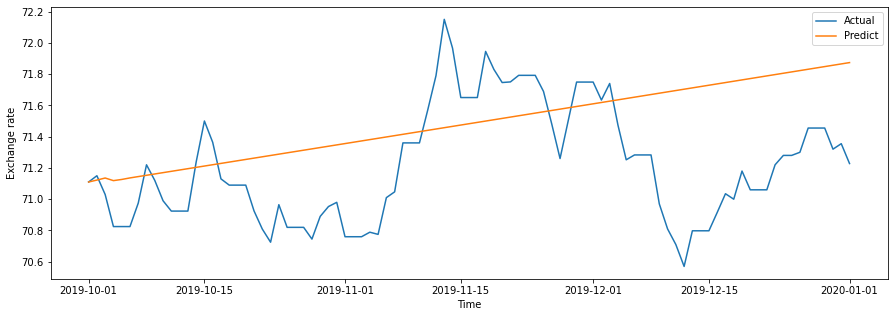

In [ ]:
print("Result for Validation dataset : \n")
arima_model_results(train_valid_log_diff, valid,'10-01-2019','01-01-2020', 2, 0, 0)

##### Testing

Result for monthly prediction : 

RMSE for AR model is: 0.3441
Mean Absolute Percent Error: 0.4%


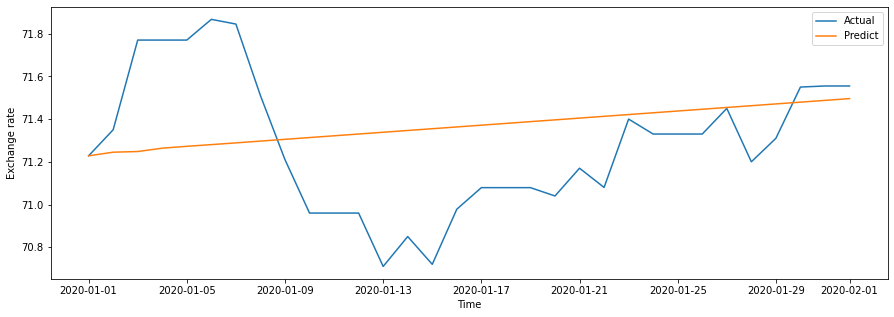


Result for yearly prediction : 

RMSE for AR model is: 3.2725
Mean Absolute Percent Error: 3.8899999999999997%


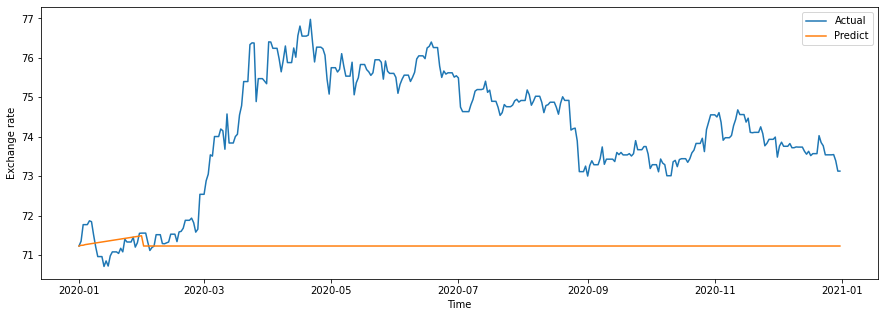

In [ ]:
print("Result for monthly prediction : \n")
arima_model_results(train_log_diff, test_month,'01-01-2020','02-01-2020', 2, 0, 0)
print("")
print("Result for yearly prediction : \n")
arima_model_results(train_log_diff, test_year,'01-01-2020','01-31-2020', 2, 0, 0)


#### MA Model
using MA(2)



##### Tuning

Result for Validation dataset : 

RMSE for AR model is: 0.4601
Mean Absolute Percent Error: 0.54%


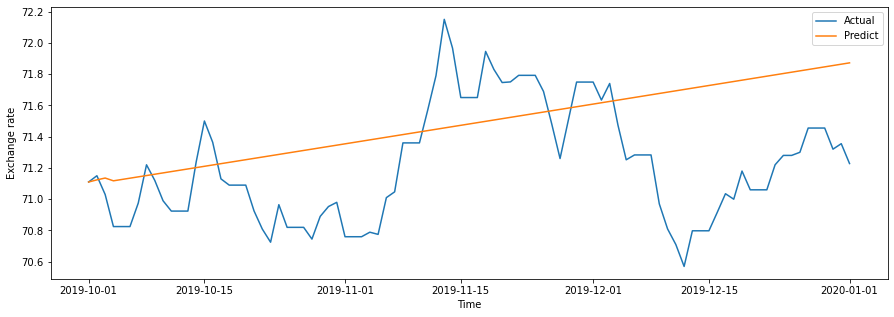

In [ ]:
print("Result for Validation dataset : \n")
arima_model_results(train_valid_log_diff, valid,'10-01-2019','01-01-2020', 0, 0, 2)

##### Testing

Result for monthly prediction : 

RMSE for AR model is: 0.3445
Mean Absolute Percent Error: 0.4%


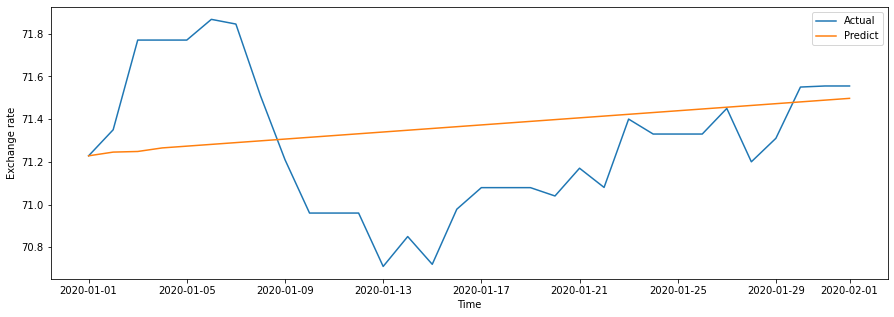


Result for yearly prediction : 

RMSE for AR model is: 3.2725
Mean Absolute Percent Error: 3.8899999999999997%


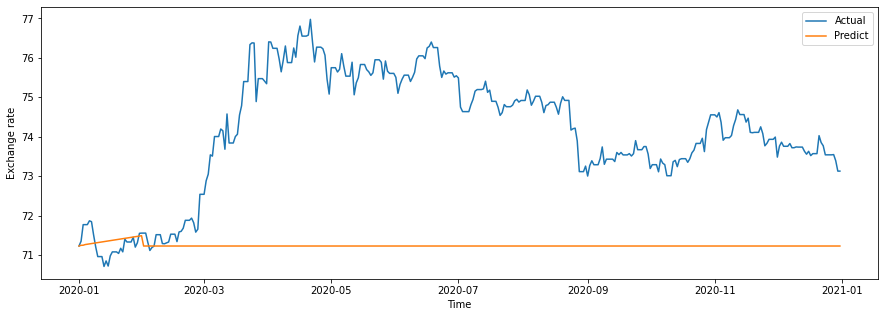

In [ ]:
print("Result for monthly prediction : \n")
arima_model_results(train_log_diff, test_month,'01-01-2020','02-01-2020', 0, 0, 2)
print("")
print("Result for yearly prediction : \n")
arima_model_results(train_log_diff, test_year,'01-01-2020','01-31-2020', 0, 0, 2)


#### ARIMA model
ARIMA(4,1,2)

Result for Validation dataset : 

RMSE for AR model is: 0.4236
Mean Absolute Percent Error: 0.49%


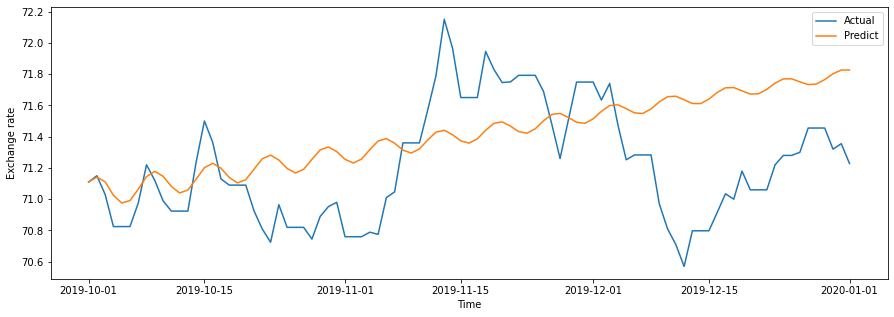

In [ ]:
print("Result for Validation dataset : \n")
arima_model_results(train_valid_log, valid,'10-01-2019','01-01-2020', 4, 1, 2)

Result for monthly prediction : 

RMSE for AR model is: 0.3436
Mean Absolute Percent Error: 0.4%


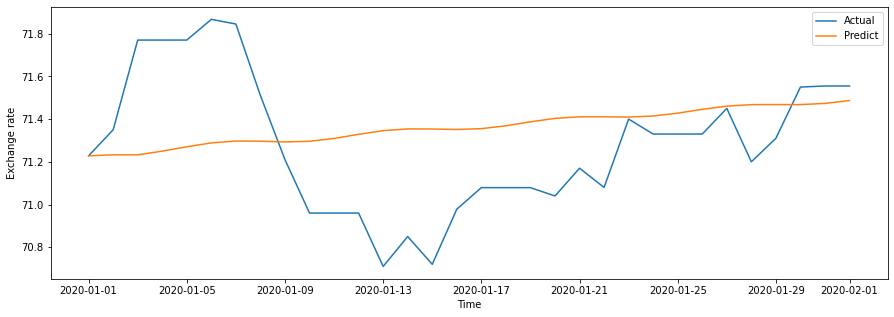


Result for yearly prediction : 

RMSE for AR model is: 3.2725
Mean Absolute Percent Error: 3.8899999999999997%


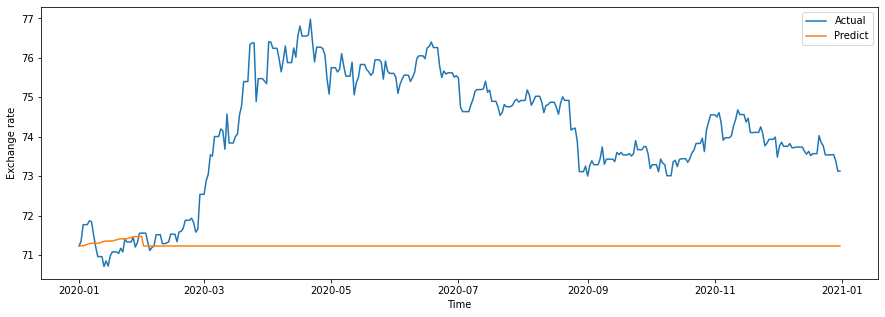

In [ ]:
print("Result for monthly prediction : \n")
arima_model_results(train_log, test_month,'01-01-2020','02-01-2020', 4, 1, 2)
print("")
print("Result for yearly prediction : \n")
arima_model_results(train_log, test_year,'01-01-2020','01-31-2020', 4, 1, 2)

### SARIMA

From PACF seasonality around 11 


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_results(train_data, test_data, start_date, end_date):

  sarima_model = SARIMAX(train_data.Price, order=(2,1,2), seasonal_order=(0,1,1,12)).fit()

  sarima_predict = sarima_model.predict(start= start_date, end= end_date)

  plt.plot(test_data['Price'], label = 'Actual')
  plt.plot(sarima_predict, label = 'SARIMA')
  plt.xlabel('Time')
  plt.ylabel('Exchange rate')
  plt.legend(loc = 'best')
  plt.show()

  residuals = test_data.Price - sarima_predict
  rmse_sarima = round(np.sqrt(np.mean(residuals**2)),4)
  mape_sarima = round(np.mean(abs(residuals/test_data.Price)),4)

  print("RMSE for SARIMA model is: "+ str(rmse_sarima))
  print("Mean Absolute Percent Error: " + str(mape_sarima*100) + "%")

Result for Validation dataset : 



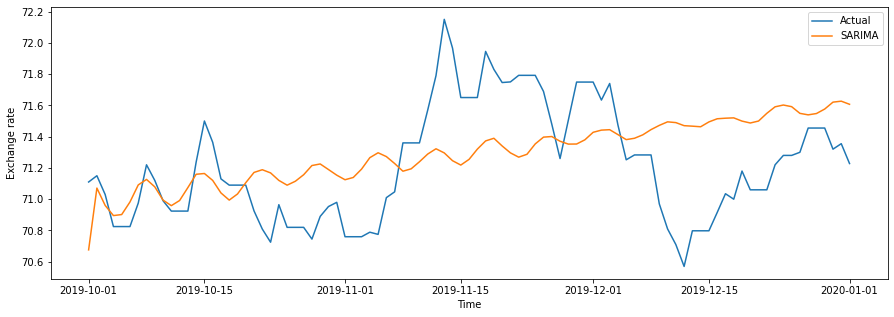

RMSE for SARIMA model is: 0.3726
Mean Absolute Percent Error: 0.44%


In [ ]:
print("Result for Validation dataset : \n")
sarima_results(train_valid, valid,'10-01-2019','01-01-2020')

Result for monthly prediction : 



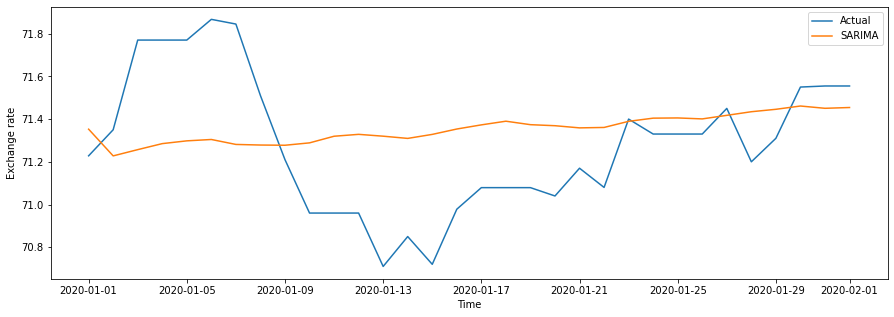

RMSE for SARIMA model is: 0.3318
Mean Absolute Percent Error: 0.38999999999999996%

Result for yearly prediction : 



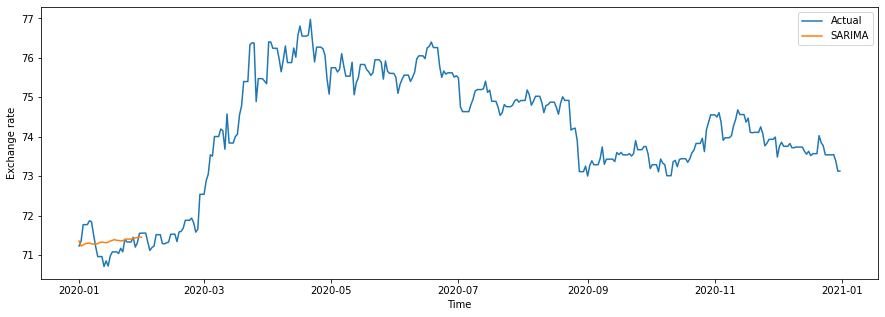

RMSE for SARIMA model is: 0.3367
Mean Absolute Percent Error: 0.4%


In [ ]:
print("Result for monthly prediction : \n")
sarima_results(train, test_month,'01-01-2020','02-01-2020')
print("")
print("Result for yearly prediction : \n")
sarima_results(train, test_year,'01-01-2020','01-31-2020')

## Prophet

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet
from prophet import Prophet

     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 184kB 37.0MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640246 sha256=f34b435d18bb3b4049a30d335d399c051614e544a8c28a6dd6d0296f60ba6e50
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
df_train = train.copy()
df_train = df_train.rename(columns={"Price":"y"})
df_train['ds'] = df_train.index
df_train.tail()

prophet_model = Prophet().fit(df_train)

prediction_month = test_month.copy()
prediction_month['ds'] = prediction_month.index
prediction_month = prediction_month.rename(columns={"Price":"y"})
prediction_month = prediction_month.drop(['year', 'month', 'day'], axis= 1)
prediction_month = prediction_month.reset_index()
prophet_predict_month = prophet_model.predict(prediction_month)

prediction_year = test_year.copy()
prediction_year['ds'] = prediction_year.index
prediction_year = prediction_year.rename(columns={"Price":"y"})
prediction_year = prediction_year.drop(['year', 'month', 'day'], axis= 1)
prediction_year = prediction_year.reset_index()
prophet_predict_year = prophet_model.predict(prediction_year)
# prophet_predict_year.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


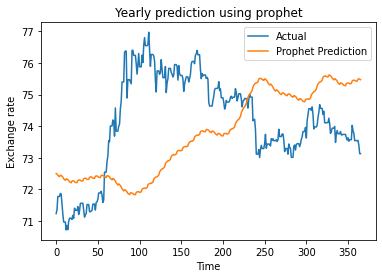

RMSE for Prophet model is: 2.0667
Mean Absolute Percent Error: 2.37%


In [ ]:
import sklearn.metrics as met
prediction_year.y.plot(label = "Actual")
prophet_predict_year.yhat.plot(label = "Prophet Prediction")
plt.xlabel('Time')
plt.title('Yearly prediction using prophet')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()

residuals = prediction_year.y - prophet_predict_year.yhat
rmse_sarima = round(np.sqrt(np.mean(residuals**2)),4)
mape_sarima = round(np.mean(abs(residuals/prediction_year.y)),4)

print("RMSE for Prophet model is: "+ str(rmse_sarima))
print("Mean Absolute Percent Error: " + str(mape_sarima*100) + "%")

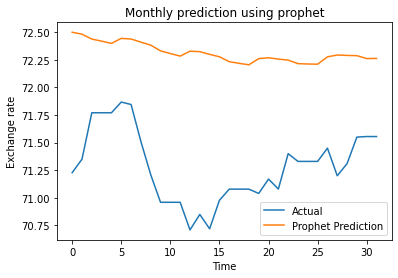

RMSE for Prophet model is: 1.0726
Mean Absolute Percent Error: 1.4500000000000002%


In [ ]:
prediction_month.y.plot(label = "Actual")
prophet_predict_month.yhat.plot(label = "Prophet Prediction")
plt.xlabel('Time')
plt.title('Monthly prediction using prophet')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()

residuals = prediction_month.y - prophet_predict_month.yhat
rmse_sarima = round(np.sqrt(np.mean(residuals**2)),4)
mape_sarima = round(np.mean(abs(residuals/prediction_month.y)),4)

print("RMSE for Prophet model is: "+ str(rmse_sarima))
print("Mean Absolute Percent Error: " + str(mape_sarima*100) + "%")